# L5: Information extraction

In [2]:
# import all the packages needed
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import spacy
from IPython.display import Image
#from collections import Counter

Information extraction (IE) is the task of **identifying named entities and semantic relations between these entities** in text data. In this lab we will focus on two sub-tasks in IE, **named entity recognition** (identifying mentions of entities) and **entity linking** (matching these mentions to entities in a knowledge base).

We start by loading spaCy:

In [3]:
import spacy

nlp = spacy.load("en_core_web_sm")

The data that we will be using has been tokenized following the conventions of the [Penn Treebank](ftp://ftp.cis.upenn.edu/pub/treebank/public_html/tokenization.html), and we need to prevent spaCy from using its own tokenizer on top of this. We therefore override spaCy&rsquo;s tokenizer with one that simply splits on space.

In [4]:
from spacy.tokens import Doc

class WhitespaceTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        return Doc(self.vocab, words=text.split(" "))

nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

## Data set

The main **data set** for this lab is a **collection of news wire articles** in which **mentions of named entities** have been annotated with page names from the [English Wikipedia](https://en.wikipedia.org/wiki/). The next code cell loads the training and the development parts of the data into Pandas data frames.

In [5]:
import bz2
import csv
import pandas as pd

with bz2.open("ner-train.tsv.bz2", 'rt') as source:
    df_train = pd.read_csv(source, sep='\t', quoting=csv.QUOTE_NONE)

with bz2.open("ner-dev.tsv.bz2", 'rt') as source:
    df_dev = pd.read_csv(source, sep='\t', quoting=csv.QUOTE_NONE)

Each row in these two data frames corresponds to one mention of a named entity and has five columns:

1. a unique identifier for the sentence containing the entity mention
2. the pre-tokenized sentence, with tokens separated by spaces
3. the start position of the token span containing the entity mention
4. the end position of the token span (exclusive, as in Python list indexing)
5. the entity label; either a **Wikipedia page name** or the **generic label** `--NME--`

The following cell prints the first five samples from the training data:

In [6]:
df_train.head()

,sentence_id,sentence,beg,end,label
0,0000-000,EU rejects German call to boycott British lamb .,0,1,--NME--
1,0000-000,EU rejects German call to boycott British lamb .,2,3,Germany
2,0000-000,EU rejects German call to boycott British lamb .,6,7,United_Kingdom
3,0000-001,Peter Blackburn,0,2,--NME--
4,0000-002,BRUSSELS 1996-08-22,0,1,Brussels


In this sample, we see that the first sentence is annotated with three entity mentions:

* the span 0–1 &lsquo;EU&rsquo; is annotated as a mention but only labelled with the generic `--NME--`
* the span 2–3 &lsquo;German&rsquo; is annotated with the page [Germany](http://en.wikipedia.org/wiki/Germany)
* the span 6–7 &lsquo;British&rsquo; is annotated with the page [United_Kingdom](http://en.wikipedia.org/wiki/United_Kingdom)

In [7]:
# print the whole sentence with the id 0000-000
df_train.loc[0]["sentence"]

'EU rejects German call to boycott British lamb .'

## Problem 1: Evaluation measures

To warm up, we ask you to write code to **print** the **three measures** that you will be using **for evaluation**:

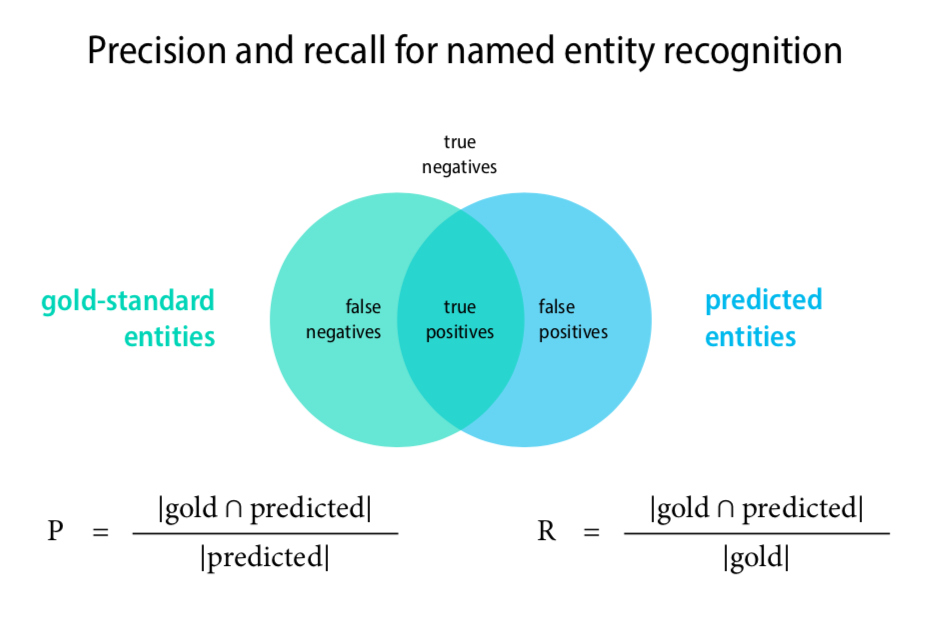

In [8]:
Image(filename = "precisionANDrecall.png", width=600, height=600)

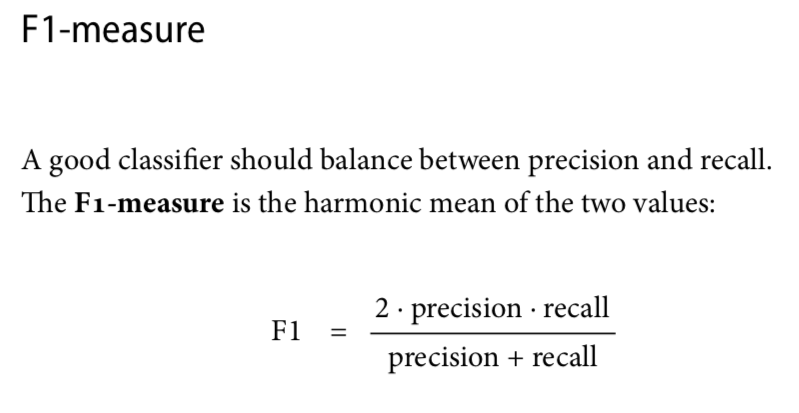

In [9]:
Image(filename = "F1score.png", width=600, height=600)

In [10]:
def evaluation_report(gold, pred):
    """Print precision, recall, and F1 score.
    
    Args:
        gold: The set with the gold-standard values.
        pred: The set with the predicted values.
    
    Returns:
        Nothing, but prints the precision, recall, and F1 values computed
        based on the specified sets.
    """
    # TODO: Replace the next line with your own code
    
    # Compute precision
    precision = len(gold.intersection(pred))/len(pred) * 100 # * 100 for percentage
    # Compute recall
    recall = len(pred.intersection(gold))/len(gold) * 100 # * 100 for percentage
    # Compute F1 score
    F1 = 2 * (precision * recall) / (precision + recall)
    
    print("precision score: {}%".format(round(precision,2)))
    print("recall score: {}%".format(round(recall,2)))
    print("F1 score: {}%".format(round(F1,2)))
    

To test your code, you can run the following cell:

In [11]:
evaluation_report(set(range(3)), set(range(5)))

precision score: 60.0%
recall score: 100.0%
F1 score: 75.0%


This should give you a precision of 60%, a recall of 100%, and an F1-value of 75%.

## Problem 2: Span recognition

One of the **first tasks** that an information extraction system has to solve is to **locate and classify (mentions of) named entities**, such as *persons and organizations*. Here we will tackle the simpler task of **recognizing spans of tokens** that contain an entity mention, without the actual entity label.

The English language model in spaCy features a full-fledged [named entity recognizer](https://spacy.io/usage/linguistic-features#named-entities) that identifies a variety of entities, and can be updated with new entity types by the user. Your task in this problem is to **evaluate the performance** of this component when **predicting entity spans** in the development data.

Start by implementing a generator function that ***yields* the gold-standard spans** in a given data frame.

**Hint:** The Pandas method [`itertuples()`](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.itertuples.html) is useful when iterating over the rows in a DataFrame.

In [12]:
df_dev.head()

,sentence_id,sentence,beg,end,label
0,0946-000,CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTE...,2,3,Leicestershire_County_Cricket_Club
1,0946-001,LONDON 1996-08-30,0,1,London
2,0946-002,West Indian all-rounder Phil Simmons took four...,0,2,West_Indies_cricket_team
3,0946-002,West Indian all-rounder Phil Simmons took four...,3,5,Phil_Simmons
4,0946-002,West Indian all-rounder Phil Simmons took four...,12,13,Leicestershire_County_Cricket_Club


In [13]:
def gold_spans(df):
    """Yield the gold-standard mention spans in a data frame.

    Args:
        df: A data frame.

    Yields:
        The gold-standard mention spans in the specified data frame as
        triples consisting of the sentence id, start position, and end
        position of each span.
    """
    
    # TODO: Replace the next line with your own code
    for row in df_dev.itertuples():
        yield row.sentence_id, row.beg, row.end
    

To test your code, you can count the spans yielded by your function. When called on the development data, you should get a **total** of **5,917** unique triples. The **first triple and the last triple** should be

    ('0946-000', 2, 3)
    ('1161-010', 1, 3)  

**Total of unique triples**

In [14]:
# check the total length

# use the gold_spans function and save as set
spans_dev_gold = set(gold_spans(df_dev))
print("Total of {} unique triples.".format(len(spans_dev_gold)))

Total of 5917 unique triples.


**first triple and the last triple**

In [15]:
# check the order of the triples
# run a for loop and print the 1 and the last element
for i, item in enumerate(spans_dev_gold):
    if i == 0:
        print(item)
    if i == (len(spans_dev_gold)-1):
        print(item)

('0960-013', 6, 7)
('1103-006', 27, 30)


** This is not the same order as expected. **

Your next task is to write code that **calls spaCy to predict the named entities in the development data**, and to **evaluate the accuracy of these predictions** in terms of precision, recall, and F1. **Print** these **scores** using the function that you wrote for Problem&nbsp;1.

In [16]:
# TODO: Write code here to run and evaluate the spaCy NER on the development data

In [17]:
def prob2_func(df):
    # want to make predictions
    # therefore we want to use spacys named Entity Recognition 
    # this we do by nlp() of a sentence, 
    # we need to access each sentence of the df (df_dev)
    
    # loop over each sentence by its index
    for sentence_index in df.sentence_id.unique():
        
        # match the index of the loop with the index of the data frame and take its sentence
        # - helpful link, how to work with iloc & loc - link below
        #print(df.loc[df.sentence_id == sentence_index, "sentence"])
        sentence = df.loc[df.sentence_id == sentence_index, "sentence"]
        sentence = sentence.values[0] # 0 - access the sentence
    
        # named Entity Recognition, we want the start and the end of entity 
        doc = nlp(sentence) 
        for ent in doc.ents:
            #print(sentence_index, ent.start, ent.end)
            yield sentence_index, ent.start, ent.end

In [18]:
# make prediction for problem 2 & save as set
pred_prob2 = set(prob2_func(df_dev))

In [19]:
evaluation_report(spans_dev_gold, pred_prob2)

precision score: 52.94%
recall score: 68.97%
F1 score: 59.9%


## Problem 3: Error analysis

As you were able to see in **Problem&nbsp;2**, the **span accuracy** of the named entity recognizer is **far from perfect**. In particular, only slightly more than half of the predicted spans are correct according to the gold standard. Your next task is to **analyse** this **result in more detail**.

**Write code** that **prints the false positives and the false negatives** from the **automatic prediction**. Have a look at the output. What are your **observations**? How could you **improve the result**? **Discuss** these questions in a short text.

In [20]:
# TODO: Write code here to do your analysis

** Print false positives and the false negatives of the prediction**

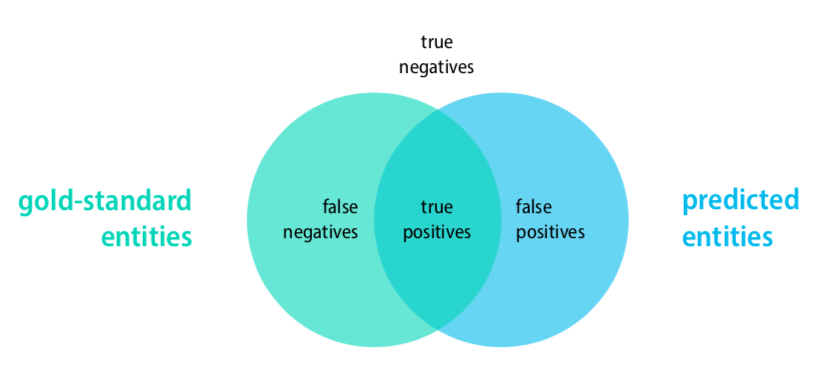

In [21]:
Image(filename = "FalsePositive_FalseNegative.png", width=600, height=600)

In [22]:
def error_analysis(gold, pred, nr_print, False_Positive = True):
    if False_Positive == True:
        # ---- Case: false positive
        print("Case: false positive")
        difference = pred.difference(gold)
    else:
        # ---- Case: false negative
        print("Case: false negative")
        difference = gold.difference(pred)
        
    # init the values I want to print later on
    difference_list = []
    difference_list_entity = []
    difference_list_both = []

    for item in difference:
        #print(item)
        # take the sentence of the sentence_id, can have multiple rows with the same sentence
        sentence = df_dev.loc[df_dev.sentence_id == item[0], ["sentence"]]
        # therefore, take the first value of the dataframe 
        sentence = sentence.iloc[0]
        # converte to string and split to access specific word
        sentence = sentence.values[0].split()
        word = sentence[item[1]:item[2]]
        # save specific word of specific item
        #difference_list.append(word)

        #------ get entitiy
        # converte list to string
        word_string = ' '.join(map(str, word))
        # get the entitiy lable of the object
        doc = nlp(word_string)
        for ent in doc.ents:
            difference_list_both.append([word_string,ent.label_])
            difference_list_entity.append(ent.label_)

    # ------------------- print the results -------------------
    # print the word with its entity
    print("The first {} word entitiy pairs:".format(nr_print))
    print(difference_list_both[0:nr_print])

    # print a count of the entities
    entity_counts = pd.Series(difference_list_entity)
    all_counts = len(entity_counts)
    entity_counts = entity_counts.value_counts()
    print("Entity types count:")
    print(entity_counts)
    print("Sum: {}".format(all_counts))

In [23]:
# error analysis - case: false positive
error_analysis(spans_dev_gold,pred_prob2,10, False_Positive = True)

Case: false positive
The first 10 word entitiy pairs:
[['73 75 72', 'CARDINAL'], ['4', 'CARDINAL'], ['10', 'CARDINAL'], ['416', 'CARDINAL'], ['9', 'CARDINAL'], ['3', 'CARDINAL'], ['third', 'ORDINAL'], ['Thursday', 'DATE'], ['65.10', 'CARDINAL'], ['1.', 'CARDINAL']]
Entity types count:
CARDINAL       1571
DATE            765
ORG             223
PERSON          169
ORDINAL         119
GPE             105
TIME             75
QUANTITY         54
PERCENT          48
MONEY            44
NORP             38
EVENT            19
LOC               8
WORK_OF_ART       3
LAW               1
dtype: int64
Sum: 3242


In [24]:
# error analysis - case: false negative
error_analysis(spans_dev_gold,pred_prob2,10, False_Positive = False)

Case: false negative
The first 10 word entitiy pairs:
[['Romania', 'GPE'], ['Hong Kong Open', 'GPE'], ['Air Cargo Newsroom', 'PRODUCT'], ['Samsung', 'ORG'], ['OFK Beograd', 'PERSON'], ['A. Dale', 'PERSON'], ['U.S. Open', 'GPE'], ['MAURITANIA', 'ORG'], ['Monica Seles', 'PERSON'], ['U.S. OPEN', 'GPE']]
Entity types count:
ORG            230
PERSON         224
GPE            158
NORP            52
DATE             9
EVENT            9
LOC              7
CARDINAL         6
WORK_OF_ART      1
PRODUCT          1
dtype: int64
Sum: 697


** Interpretation **

- **Case: false positive**

It can be seen that especially often numbers like the category Cardinal & date were wrongly classified.
These are by far the most common mistakes. 

- **Case: false negative**

Here it can be seen that organizations and individuals are generated the most misclassifications, as well as countries. 

However, these have a similar number of errors to the false positive case. Overall, the false positive case has a much higher number of errors than the false negative case. 

To improve the score, a similar procedure as in problem 3 could be performed, but without the entity types with the most errors.


Now, use the insights from your error analysis to improve the automated prediction that you implemented in Problem&nbsp;2. While the best way to do this would be to [update spaCy&rsquo;s NER model](https://spacy.io/usage/linguistic-features#updating) using domain-specific training data, for this lab it suffices to **write code to pre-process the data and/or post-process the output produced by spaCy**. You should be able to **improve** the **F1 score from Problem&nbsp;2 by at last 15 percentage points**.

In [25]:
# TODO: Write code here to improve the span prediction from Problem 2

In [26]:
# code as in prob2_func + light modifications
def prob3_func(df):
        for indx in df.sentence_id.unique():
            sentence = df.loc[df.sentence_id==indx,'sentence']
            doc = nlp(sentence.values[0])
            for ent in doc.ents:
                # modification at this part
                # exclude some specific Named Entity Recognition
                # ---- Test combinations
                #if ent.label_ not in ['CARDINAL', 'DATE', 'ORG', 'Person', 'GPE']:
                #if ent.label_ not in ['CARDINAL', 'DATE', 'ORG', 'PERSON', 'ORDINAL', 'GPE', 'TIME', 'QUANTITY','PERCENT','MONEY','NORP', 'EVENT']:
                # ----
                if ent.label_ not in ['CARDINAL', 'ORDINAL', 'QUANTITY', 'MONEY', 'PERCENT', 'TIME', 'DATE']:
                    yield indx,ent.start,ent.end
# make predictions on the same dataset with the new function                   
new_preds = set(prob3_func(df_dev))

**Show** that you achieve the **performance goal** by reporting the evaluation measures that you implemented in Problem&nbsp;1.

In [27]:
evaluation_report(spans_dev_gold,new_preds)

precision score: 84.48%
recall score: 68.89%
F1 score: 75.89%


In [28]:
print("The F1 score improved by {} %.".format(round(75.89-59.9,3)))

The F1 score improved by 15.99 %.


Before going on, we ask you to **store** the **outputs of the improved named entity recognizer on the development data in a new data frame**. This **new frame** should have the **same layout as the original data frame for the development data** that you loaded above, but should contain the predicted start and end positions for each token span. As the `label` of **each span**, you can use the **special value** `--NME--`.

In [29]:
# TODO: Write code here to store the predicted spans in a new data frame

In [30]:
# save the prediction as list
preds_list = list(new_preds)

x=[item[0] for item in preds_list]
y=[item[1] for item in preds_list]
z=[item[2] for item in preds_list]

# create a list with the indexes for each predicted span
indexes_list = []
for i in range(len(x)):
    indexes_list.append(df_dev.index[(df_dev['sentence_id']==x[i]) & (df_dev['beg']==y[i]) & (df_dev['end']==z[i])].tolist())
    

In [31]:
from functools import reduce
# flatten the indexes list 
flat_list = reduce(lambda x, y: x+y, indexes_list)

In [32]:
# create the dataframe
df_dev_small = df_dev.iloc[flat_list,:]
df_dev_small.drop(['label'],axis=1)
df_dev_small.label='--NME--'
df_dev_small.head(n=10)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,sentence_id,sentence,beg,end,label
517,0960-013,"The hard-serving O'Brien , a former U.S. colle...",6,7,--NME--
1293,0983-001,LONDON 1996-08-30,0,1,--NME--
4394,1097-003,"Refusing to go quietly in the night , Stefan E...",21,23,--NME--
5112,1127-008,Russian military officials have expressed fear...,18,19,--NME--
4069,1089-006,He is striving for his fourth career PGA Tour ...,7,9,--NME--
5714,1153-002,Two Belgian teenage girls missing since Thursd...,1,2,--NME--
3267,1059-004,Kent will also need to keep their nerve agains...,29,31,--NME--
4476,1099-018,"Scotland : Andrew Goram , Craig Burley , Thoma...",2,4,--NME--
901,0966-122,7. Pyotr Bochkary ( Russia ) 5.65,4,5,--NME--
2749,1046-007,Shortly afterwards Roberto Carlos found space ...,25,27,--NME--


## Problem 4: Entity linking

Now that we have a method for predicting mention spans, we turn to the task of **entity linking**, which amounts to predicting the knowledge base entity that is referenced by a given mention. In our case, **for each span we want to predict the Wikipedia page that this mention references**.

Start by **extending** the generator function that you implemented in **Problem&nbsp;2** to labelled spans.

In [33]:
def gold_mentions(df):
    """Yield the gold-standard mentions in a data frame.

    Args:
        df: A data frame.

    Yields:
        The gold-standard mention spans in the specified data frame as
        quadruples consisting of the sentence id, start position, end
        position and entity label of each span.
    """
    
    # TODO: Replace the next line with your own code
    # code from Probem 2 - gold_spans
    for row in df_dev.itertuples():
        # added lables
        yield row.sentence_id, row.beg, row.end, row.label 

A **naive baseline for entity linking** on our data set is to **link each mention span to the Wikipedia page name** that we get when we ***join* the tokens in the span by underscores**, as is standard in Wikipedia page names. Suppose, **for example**, that a span contains the two tokens

    Jimi Hendrix

The baseline Wikipedia page name for this span would be

    Jimi_Hendrix

**Implement** this **naive baseline and evaluate its performance**. Print the evaluation measures that you implemented in Problem&nbsp;1.

<div class="alert alert-warning">
    Here and in the remainder of this lab, you should base your entity predictions on the predicted spans that you computed in Problem&nbsp;3.
</div>

In [34]:
# TODO: Write code here to implement the baseline

In [35]:
df_dev_small.head(10)

,sentence_id,sentence,beg,end,label
517,0960-013,"The hard-serving O'Brien , a former U.S. colle...",6,7,--NME--
1293,0983-001,LONDON 1996-08-30,0,1,--NME--
4394,1097-003,"Refusing to go quietly in the night , Stefan E...",21,23,--NME--
5112,1127-008,Russian military officials have expressed fear...,18,19,--NME--
4069,1089-006,He is striving for his fourth career PGA Tour ...,7,9,--NME--
5714,1153-002,Two Belgian teenage girls missing since Thursd...,1,2,--NME--
3267,1059-004,Kent will also need to keep their nerve agains...,29,31,--NME--
4476,1099-018,"Scotland : Andrew Goram , Craig Burley , Thoma...",2,4,--NME--
901,0966-122,7. Pyotr Bochkary ( Russia ) 5.65,4,5,--NME--
2749,1046-007,Shortly afterwards Roberto Carlos found space ...,25,27,--NME--


In [36]:
# function to create predictions
def prob4_func(df):
    # run every row of the df
    for row in range(df_dev_small.shape[0]):
        # get the sentence_id 
        sentence_id = df_dev_small.iloc[row,0]
        
        # get the beg and the end of specific word
        beg = df_dev_small.iloc[row,2]
        end = df_dev_small.iloc[row,3]
        
        # access every word of the sentence
        sentence = df_dev_small.iloc[row,1].split()
        # filter for word(s) we want to have
        word = sentence[beg:end]
        
        # join the words with "_"
        words = "_".join(word)
        
        yield sentence_id, beg, end, words
# make predictions 
preds4 = set(prob4_func(df_dev_small))

In [37]:
# use the gold_mentions function and save as set
gold_mentions_set = set(gold_mentions(df_dev_small))

In [38]:
# evaluation
evaluation_report(gold_mentions_set,preds4)

precision score: 37.68%
recall score: 25.96%
F1 score: 30.74%


## Problem 5: Extending the training data using the knowledge base

State-of-the-art approaches to **entity linking exploit information in knowledge bases**. In our case, where **Wikipedia is the knowledge base**, one particularly useful type of information are links to other Wikipedia pages. In particular, we can **interpret the anchor texts** (the highlighted texts that you click on when you click on a link) as **mentions of the entities** (pages) that they link to. This allows us to harvest long lists over mention–entity pairings.

The following cell loads a data frame summarizing anchor texts and page references harvested from the first paragraphs of the English Wikipedia. The data frame also contains all entity mentions in the training data (but not the development or the test data).

In [39]:
with bz2.open("kb.tsv.bz2", 'rt') as source:
    df_kb = pd.read_csv(source, sep='\t', quoting=csv.QUOTE_NONE)

To understand what information is available in this data, the following cell shows the entry for the anchor text `Sweden`.

In [40]:
df_kb.loc[df_kb["mention"] == "Sweden"]

,mention,entity,prob
17436,Sweden,Sweden,0.985768
17437,Sweden,Sweden_national_football_team,0.014173
17438,Sweden,Sweden_men's_national_ice_hockey_team,0.000059


As you can see, **each row** of the data frame **contains a pair $(m, e)$ of a mention $m$ and an entity $e$**, as well as the **conditional probability $P(e|m)$ for mention $m$ referring to entity $e$**. These probabilities were **estimated based on the frequencies of mention–entity pairs in the knowledge base**. The **example** shows that the **anchor text &lsquo;Sweden&rsquo;** is most often used to refer to the entity [Sweden](http://en.wikipedia.org/wiki/Sweden), but in a few cases also to refer to Sweden&rsquo;s national football and ice hockey teams. Note that references are sorted in decreasing order of probability, so that the **most probable pairing stands first**.

**Implement** an **entity linking method** that **resolves each mention to the most probable entity in the data frame**. If the mention is not included in the data frame, you can predict the generic label `--NME--`. **Print the precision, recall, and F1** of your method using the function that you implemented for Problem&nbsp;1.

In [41]:
# TODO: Write code here to implement the "most probable entity" method.

In [42]:
df_kb.head()

,mention,entity,prob
0,000 Guineas,2000_Guineas_Stakes,1.0
1,10 00,United_States_dollar,1.0
2,126 million,United_States_dollar,1.0
3,13th dynasty,Middle_Kingdom_of_Egypt,1.0
4,14th Dalai Lama,14th_Dalai_Lama,1.0


In [43]:
# gold-standard for problem 5
def gold_mention_entitiy(df):
    # TODO: Replace the next line with your own code
    # code from Probem 2 - gold_spans
    for row in df.itertuples():
        # added lables
        yield row.mention, row.entity

# create gold standard
gold_mention_entity_set = set(gold_mention_entitiy(df_kb))
#print(gold_mention_entity_set)

In [44]:
# function to create predictions
def prob5_func(df):
    # run every row of the df
    for row in range(df.shape[0]):
        # get the mention 
        mention = df.iloc[row,0]
        
        # get entity with highest prob
        mention_df = df.loc[df["mention"] == mention]
        
        ### ------ flag ------
        # if df not empty -> take highest prob
        # else -- NME --
        if mention_df.shape[0] != 0:
            mention_df_highest_entity = mention_df.iloc[0,1]
            yield mention, mention_df_highest_entity
        else:
            yield mention, "--NME--" 
# make predictions
preds5 = set(prob5_func(df_kb))
#print(preds5)

In [45]:
# evaluation
evaluation_report(gold_mention_entity_set,preds5)

precision score: 100.0%
recall score: 90.12%
F1 score: 94.8%


## Problem 6: Context-sensitive disambiguation

Consider the **entity mention &lsquo;Lincoln&rsquo;**. The **most probable entity** for this mention turns out to be **[Lincoln, Nebraska](http://en.wikipedia.org/Lincoln,_Nebraska)**; but in pages about American history, we would be **better off to predict [Abraham Lincoln](http://en.wikipedia.org/Abraham_Lincoln)**. This suggests that we should **try to disambiguate between different entity references based on the textual context on the page from which the mention was taken**. Your task in this last problem is to implement this idea.

**Set up** a **dictionary** that **contains**, for each **mention $m$ that can refer to more than one entity $e$**, a **separate Naive Bayes classifier to predict the correct entity $e$**, given the textual context of the mention. As the prior probabilities of the classifier, **choose** the **probabilities $P(e|m)$** that you used in Problem&nbsp;5. To let you **estimate the context-specific probabilities**, we have compiled a data set with mention contexts:

In [50]:
with bz2.open("contexts.tsv.bz2") as source:
    df_contexts = pd.read_csv(source, sep='\t', quoting=csv.QUOTE_NONE)

This **data frame contains**, for each **ambiguous mention $m$ and each knowledge base entity $e$ to which this mention can refer**, up to 100 randomly selected contexts in which $m$ is used to refer to $e$. For this data, a **context** is **defined as a bag of words** containing the mention itself, as well as the 5 tokens to the left and the 5 tokens to the right of the mention. Here are a few examples:

In [47]:
df_contexts.head()

,mention,entity,context
0,1970,UEFA_Champions_League,Cup twice the first in 1970 and the second in ...
1,1970,FIFA_World_Cup,America 1975 and during the 1970 and 1978 Worl...
2,1990 World Cup,1990_FIFA_World_Cup,Manolo represented Spain at the 1990 World Cup
3,1990 World Cup,1990_FIFA_World_Cup,Hašek represented Czechoslovakia at the 1990 W...
4,1990 World Cup,1990_FIFA_World_Cup,renovations in 1989 for the 1990 World Cup The...


From this data frame, it is easy to select the data that you need to train the classifiers – the contexts and corresponding entities for all mentions. To illustrate this, the following cell **shows how to select all contexts that belong to the mention &lsquo;Lincoln&rsquo;**:

In [48]:
df_contexts.context[df_contexts.mention == "Lincoln"]

41465    Nebraska Concealed Handgun Permit In Lincoln m...
41466    Lazlo restaurants are located in Lincoln and O...
41467    California Washington Overland Park Kansas Lin...
41468    City Missouri Omaha Nebraska and Lincoln Nebra...
41469    by Sandhills Publishing Company in Lincoln Neb...
                               ...                        
41609                                Lincoln Leyton Orient
41610               English division three Swansea Lincoln
41611    league membership narrowly edging out Lincoln ...
41612                                    Lincoln Cambridge
41613                                              Lincoln
Name: context, Length: 149, dtype: object

**Implement the context-sensitive disambiguation method and evaluate its performance**. Here are some more hints that may help you along the way:

**Hint 1:** The **prior probabilities** for a Naive Bayes classifier can be **specified using** the `class_prior` option. You will have to provide the **probabilities** in the same **order as the alphabetically sorted** class (entity) names.

**Hint 2:** To **tune** the **performance of your method**, you can try to **tweak the behaviour of the vectorizer** (for example, should it apply lowercasing or not?) and the **width of the window** from which you are extracting context tokens at prediction time.

**Hint 3:** Not all mentions in the knowledge base are ambiguous, and therefore not all mentions have context data. If a mention has only **one possible entity, pick that one. If a mention has no entity at all, predict the `--NME--` label**.

In [49]:
# TODO: Write code here to implement the context-sensitive disambiguation method

You should **expect** to see a **small (around 1&nbsp;unit) increase** in both precision, recall, and F1. Published systems report a larger impact of context-sensitive disambiguation. Feel free to think about what could explain the relatively minor impact that we see here!

**Interpretation of the results**

**This was the last lab in the Text Mining course. Well done!**

<div class="alert alert-info">
    Please read the section ‘General information’ on the ‘Labs’ page of the course website before submitting this notebook!
</div>

**Helpful links**

- Problem 1

https://www.geeksforgeeks.org/intersection-function-python/

- Problem 2

https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/

https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

- Problem 3

https://dev.to/svinci/intersection-union-and-difference-of-sets-in-python-4gkn